# Selección de variables y regularización
_Santander Meteorology Group (21-01-2019)_

 * [Introducción](#Introducción)
 * [Base de datos de ejemplo: Breast cancer](#Base-de-datos:-Breast-cancer)
 * [Modelo lineal completo](#Modelo-lineal-completo)
 * [Selección de variables](#Selección-de-variables)
 * [Regularización](#Regularización)

## Introducción
El objetivo principal de un modelo entrenado es que tenga la capacidad de generalizar, es decir, la capacidad de predecir bien nuevos datos que no formen parte de la muestra de entrenamiento (por ejemplo, una muestra de datos de _test_). La relación entre el número de observaciones y el número de variables independientes es clave en la capacidad de generalización de los modelos.

Para evitar el sobreajuste en situaciones donde el número de observaciones es del orden, o menor, que el de grados de libertad del sistema y/o donde hay colinealidad, se utilizan (entre otras) técnicas como la selección de variables y la regularización. La primera permite seleccionar de forma objetiva un subconjunto de variables predictoras, mientras que la segunda actúa sobre los parámetros del modelo, impidiendo que tomen valores elevados que harían al modelo muy sensible a diferentes muestras de entrenamiento.

## Base de datos: Breast cancer

En este ejemplo trabajaremos con la base de datos [_Breast cancer_ (Diagnostic)](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), incluida en Kaggle. El objetivo de este conjunto de datos es clasificar a las pacientes en base a si el cáncer de mama que tienen es benigno (`B`) o maligno (`M`). Para ello se utilizan 31 predictores relacionados con las propiedades de las células cancerígenas, que en comparación con el número de observaciones (569) es bajo.

### ::GMG:: Carga y Limpieza

Preparamos la base de datos de la siguiente manera:

In [1]:
#::GMG::Cargo los datos en formato csv de un archivo local
#::nota::También se puede bajar del repositorio de UCI ... pero requiere pre-proceso
# https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
data <- read.csv("breastcancer.csv")

In [2]:
#::GMG::Echo un vistazo al dataset que he cargado
str(data)

'data.frame':	569 obs. of  33 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se            

In [3]:
#::GMG::Elimino variables (id, que no aporta información y X que es NA)
#::nota::se crea un nuevo dataframe para almacenar el dataset 2limpio"
df <- data[, -c(1, ncol(data)-1, ncol(data))]

In [4]:
#::GMG::se borra el dataset antiguo de la memoria
rm(data)

In [5]:
#::GMG::Se convierte el factor diagnosis (B y M) a numeric con valores 0 y 1
#::DUDA::¿Por qué?
# https://www.rdocumentation.org/packages/base/versions/3.5.2/topics/levels
# https://stackoverflow.com/questions/52245719/performing-lasso-regularization-with-factors-and-numeric-predictors
levels(df$diagnosis)

[1] "B" "M"

In [6]:
str(df$diagnosis)

 Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...


In [7]:
#::GMG::Primero se pone a 0s y 1s en vez de 'B' y 'M'
levels(df$diagnosis) <- c(0,1) 

In [8]:
str(df$diagnosis)

 Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


In [9]:
#::GMG::Se hace  la conversión factor -> numeric
# https://stackoverflow.com/questions/3418128/how-to-convert-a-factor-to-integer-numeric-without-loss-of-information
#::nota::se recomienda (más eficiente)
df$diagnosis <- as.numeric(levels(df$diagnosis))[df$diagnosis]
#df$diagnosis <- as.numeric(as.character(df$diagnosis))

In [10]:
str(df$diagnosis)

 num [1:569] 1 1 1 1 1 1 1 1 1 1 ...


In [11]:
#::GMG::Hecho un vistazo a los estadísticos de las variables numéricas
#::nota::tiene que ver con el escalado que viene ...
summary(df)

   diagnosis       radius_mean      texture_mean   perimeter_mean  
 Min.   :0.0000   Min.   : 6.981   Min.   : 9.71   Min.   : 43.79  
 1st Qu.:0.0000   1st Qu.:11.700   1st Qu.:16.17   1st Qu.: 75.17  
 Median :0.0000   Median :13.370   Median :18.84   Median : 86.24  
 Mean   :0.3726   Mean   :14.127   Mean   :19.29   Mean   : 91.97  
 3rd Qu.:1.0000   3rd Qu.:15.780   3rd Qu.:21.80   3rd Qu.:104.10  
 Max.   :1.0000   Max.   :28.110   Max.   :39.28   Max.   :188.50  
   area_mean      smoothness_mean   compactness_mean  concavity_mean   
 Min.   : 143.5   Min.   :0.05263   Min.   :0.01938   Min.   :0.00000  
 1st Qu.: 420.3   1st Qu.:0.08637   1st Qu.:0.06492   1st Qu.:0.02956  
 Median : 551.1   Median :0.09587   Median :0.09263   Median :0.06154  
 Mean   : 654.9   Mean   :0.09636   Mean   :0.10434   Mean   :0.08880  
 3rd Qu.: 782.7   3rd Qu.:0.10530   3rd Qu.:0.13040   3rd Qu.:0.13070  
 Max.   :2501.0   Max.   :0.16340   Max.   :0.34540   Max.   :0.42680  
 concave.points_mean

In [12]:
#::GMG::Normalizar los datos para evitar problemas de diferente variabilidad
#::nota::no se normaliza la viariable binaria numérica diagnosis (!)
df[-1] <- apply(df[-1], MARGIN = 2, scale)

In [13]:
#::GMG::Se puede ver el 'cambio' (todos tienen  media casi cero y varianza 1)
summary(df)

   diagnosis       radius_mean       texture_mean     perimeter_mean   
 Min.   :0.0000   Min.   :-2.0279   Min.   :-2.2273   Min.   :-1.9828  
 1st Qu.:0.0000   1st Qu.:-0.6888   1st Qu.:-0.7253   1st Qu.:-0.6913  
 Median :0.0000   Median :-0.2149   Median :-0.1045   Median :-0.2358  
 Mean   :0.3726   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:1.0000   3rd Qu.: 0.4690   3rd Qu.: 0.5837   3rd Qu.: 0.4992  
 Max.   :1.0000   Max.   : 3.9678   Max.   : 4.6478   Max.   : 3.9726  
   area_mean       smoothness_mean    compactness_mean  concavity_mean   
 Min.   :-1.4532   Min.   :-3.10935   Min.   :-1.6087   Min.   :-1.1139  
 1st Qu.:-0.6666   1st Qu.:-0.71034   1st Qu.:-0.7464   1st Qu.:-0.7431  
 Median :-0.2949   Median :-0.03486   Median :-0.2217   Median :-0.3419  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.3632   3rd Qu.: 0.63564   3rd Qu.: 0.4934   3rd Qu.: 0.5256  
 Max.   : 5.2459   Max.   : 4.76672   Max.   : 4.564

In [14]:
paste (mean(df$area_worst), var(df$area_worst), sd(df$area_worst))

[1] "6.73424836203562e-18 1 1"

In [15]:
#::GMG::Tamaño del dataset
dim(df)

[1] 569  30

In [16]:
#::GMG::Nombres de las columnas (features y clase 'diagnosis')
names(df)

[1] "diagnosis"              "radius_mean"            "texture_mean"          
 [4] "perimeter_mean"         "area_mean"              "smoothness_mean"       
 [7] "compactness_mean"       "concavity_mean"         "concave.points_mean"   
[10] "symmetry_mean"          "fractal_dimension_mean" "radius_se"             
[13] "texture_se"             "perimeter_se"           "area_se"               
[16] "smoothness_se"          "compactness_se"         "concavity_se"          
[19] "concave.points_se"      "symmetry_se"            "fractal_dimension_se"  
[22] "radius_worst"           "texture_worst"          "perimeter_worst"       
[25] "area_worst"             "smoothness_worst"       "compactness_worst"     
[28] "concavity_worst"        "concave.points_worst"   "symmetry_worst"

### ::GMG:: Exploración

In [17]:
#::GMG::levelplot() included :)
# https://cran.r-project.org/web/packages/lattice/index.html
library(lattice) 

In [18]:
#::GMG::Visualización de la correlación entre las diferentes variables del dataset
# https://www.rdocumentation.org/packages/stats/versions/3.5.2/topics/cor
# http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software
cor(df)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,⋯,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst
diagnosis,1.000000000,0.73002851,0.415185300,0.742635530,0.70898384,0.35855997,0.59653368,0.69635971,0.77661384,0.33049855,⋯,0.077972417,0.77645378,0.456902821,0.782914137,0.73382503,0.42146486,0.59099824,0.65961021,0.7935660,0.41629431
radius_mean,0.730028511,1.00000000,0.323781891,0.997855281,0.98735717,0.17058119,0.50612358,0.67676355,0.82252852,0.14774124,⋯,-0.042641269,0.96953897,0.297007644,0.965136514,0.94108246,0.11961614,0.41346282,0.52691146,0.7442142,0.16395333
texture_mean,0.415185300,0.32378189,1.000000000,0.329533059,0.32108570,-0.02338852,0.23670222,0.30241783,0.29346405,0.07140098,⋯,0.054457520,0.35257295,0.912044589,0.358039575,0.34354595,0.07750336,0.27782959,0.30102522,0.2953158,0.10500791
perimeter_mean,0.742635530,0.99785528,0.329533059,1.000000000,0.98650680,0.20727816,0.55693621,0.71613565,0.85097704,0.18302721,⋯,-0.005523391,0.96947636,0.303038372,0.970386887,0.94154981,0.15054940,0.45577423,0.56387926,0.7712408,0.18911504
area_mean,0.708983837,0.98735717,0.321085696,0.986506804,1.00000000,0.17702838,0.49850168,0.68598283,0.82326887,0.15129308,⋯,-0.019886963,0.96274609,0.287488627,0.959119574,0.95921333,0.12352294,0.39041031,0.51260592,0.7220166,0.14356991
smoothness_mean,0.358559965,0.17058119,-0.023388516,0.207278164,0.17702838,1.00000000,0.65912322,0.52198377,0.55369517,0.55777479,⋯,0.283606699,0.21312014,0.036071799,0.238852626,0.20671836,0.80532420,0.47246844,0.43492571,0.5030534,0.39430948
compactness_mean,0.596533678,0.50612358,0.236702222,0.556936211,0.49850168,0.65912322,1.00000000,0.88312067,0.83113504,0.60264105,⋯,0.507318127,0.53531540,0.248132833,0.590210428,0.50960381,0.56554117,0.86580904,0.81627525,0.8155732,0.51022343
concavity_mean,0.696359707,0.67676355,0.302417828,0.716135650,0.68598283,0.52198377,0.88312067,1.00000000,0.92139103,0.50066662,⋯,0.449300749,0.68823641,0.299878889,0.729564917,0.67598723,0.44882204,0.75496802,0.88410264,0.8613230,0.40946413
concave.points_mean,0.776613840,0.82252852,0.293464051,0.850977041,0.82326887,0.55369517,0.83113504,0.92139103,1.00000000,0.46249739,⋯,0.257583746,0.83031763,0.292751713,0.855923128,0.80962962,0.45275305,0.66745368,0.75239950,0.9101553,0.37574415
symmetry_mean,0.330498554,0.14774124,0.071400980,0.183027212,0.15129308,0.55777479,0.60264105,0.50066662,0.46249739,1.00000000,⋯,0.331786146,0.18572775,0.090650688,0.219168559,0.17719338,0.42667503,0.47320001,0.43372101,0.4302966,0.69982580


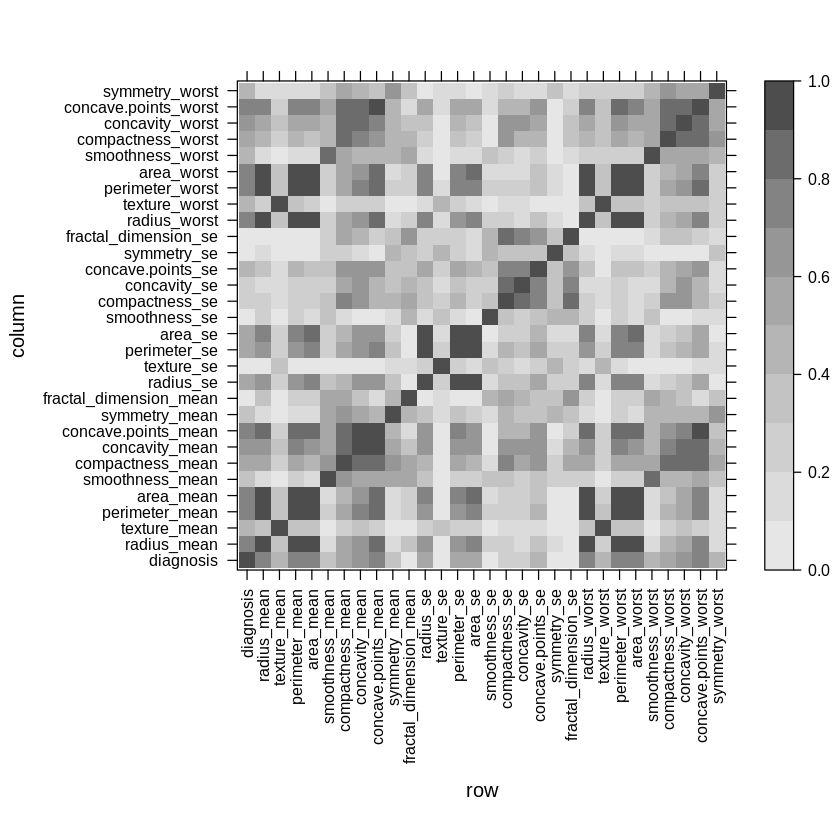

In [19]:
# https://www.rdocumentation.org/packages/lattice/versions/0.10-10/topics/levelplot
# https://www.rdocumentation.org/packages/lattice/versions/0.10-10/topics/xyplot
#::nota::para ver los niveles en color solamente interesa el valor absoluto
#::nota::supongo que se podría poner un código de colores para ver diferencuas + o -
cor.matrix <- abs(cor(df))
levelplot(cor.matrix, at = seq(0, 1, 0.1), col.regions = rev(grey.colors(10)),
          scale = list(x = list(rot = 90)))

**::GMG::** Se puede ver claramente la correlación entre features relacionados con la *topología* del posible tumor (perimeter, area, radius, ... concavity and concave_points ...)


  0   1 
357 212 

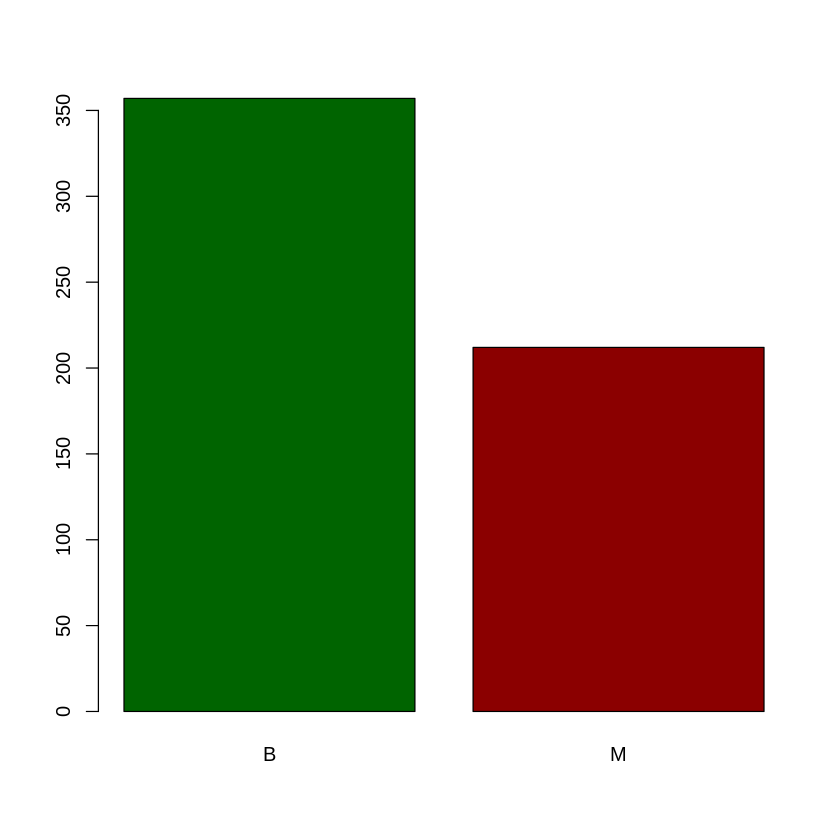

In [20]:
#::GMG::Se me ha ocurrido que puede ser interesante ver la proporción de clases en el dataset
table(df$diagnosis)
barplot(height = table(df$diagnosis),
        col = c('darkgreen','darkred'),
        names.arg = c('B','M'))

**::GMG::** Vemos que no hay balance entre clases. Esto puede dar problemas al aplicar algoritmos de clasificación. Aunque en el caso específico de una regresión logística los efectos son limitados y podrían solucionarse:

- StackExchange Cross Validated [Does an unbalanced sample matter when doing logistic regression?](https://stats.stackexchange.com/questions/6067/does-an-unbalanced-sample-matter-when-doing-logistic-regression)

> For logistic regression models unbalanced training data affects only the estimate of the model intercept (although this of course skews all the predicted probabilities, which in turn compromises your predictions). Fortunately the intercept correction is straightforward: Provided you know, or can guess, the true proportion of 0s and 1s and know the proportions in the training set you can apply a rare events correction to the intercept. Details are in [King and Zeng (2001)](https://gking.harvard.edu/files/abs/0s-abs.shtml)

## Modelo lineal completo

### ::GMG:: Bibliotecas

In [12]:
#install.packages("verification")
#install.packages("caret")
#install.packages("e1071")

Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘dotCall64’, ‘spam’, ‘maps’, ‘proxy’, ‘fields’, ‘boot’, ‘CircStats’, ‘dtw’



In [21]:
library(verification, quietly = TRUE) # roc.area
library(caret, quietly = TRUE) # confusionMatrix

Spam version 2.2-1 (2018-12-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 

Attaching package: ‘boot’

The following object is masked from ‘package:lattice’:

    melanoma


Attaching package: ‘proxy’

The following object is masked from ‘package:spam’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.



### ::GMG:: Full Model

Ahora construimos el modelo lineal mediante la función glm. Como la variable respuesta sigue una distribución de Bernouilli lo más apropiado es realizar una regresión logística.

In [22]:
#::GMG::Modelo con glm() con binomial y supongo que link 'logit'
#       osea, una sigmoid
#
# https://en.wikipedia.org/wiki/Logit
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/glm.html
# https://www.rdocumentation.org/packages/stats/versions/3.5.2/topics/glm
# https://www.statmethods.net/advstats/glm.html
# 
#::nota::aparece un mensaje de warning ...
# “glm.fit: fitted probabilities numerically 0 or 1 occurred”
#::DUDA:: uhm, ese warning .... me concierne :?
#::DUDA:: ¿Porqué no se ha hecho de entrada un train/test con CV en train?
model <- glm(diagnosis ~ ., data = df, family = "binomial")

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

### ::GMG:: Diagnóstico

In [24]:
#::GMG::Echo un vistazo a los coeficientes
#::nota::son grandes, eso no es muy buena señal ...
#::nota::están en unidades 'logits', por cierto
coefficients(model)

(Intercept)            radius_mean           texture_mean 
             99.204714            -832.265701              40.790142 
        perimeter_mean              area_mean        smoothness_mean 
             56.651806             646.527540               1.063020 
      compactness_mean         concavity_mean    concave.points_mean 
           -160.975402              95.363713              84.857577 
         symmetry_mean fractal_dimension_mean              radius_se 
            -18.831560              44.518821             140.704484 
            texture_se           perimeter_se                area_se 
              9.520031            -155.475725              93.619934 
         smoothness_se         compactness_se           concavity_se 
            -14.373238              39.400251             -80.390203 
     concave.points_se            symmetry_se   fractal_dimension_se 
             87.763486             -30.678883             -67.658358 
          radius_worst          texture_worst        perimeter_worst 
             81.177387               5.968340             211.434319 
            area_worst       smoothness_worst      compactness_worst 
             74.371876              28.756964              33.912577 
       concavity_worst   concave.points_worst         symmetry_worst 
             15.325038              36.185676              49.737758

In [25]:
#::GMG::Veo el sumario y me fijo en el std error y p-value  de los coeficientes ... 
#       uy, mal! :) TODOS son non-significant (p > 0.05) y los erroes son GRANDES
#::nota::la métrica 'deviance' que mide el 'badness of fit' tiene un valor alto
#        en el caso de usar solo el intercept (null deviance) y se reduce 
#        de manera importante al incluir todos los features (residual deviance) ...
#::DUDA::¿y eso que significa respecto al 'badness' de nuestro modelo?
#::DUDA::¿cómo se interpreta el Deviance residuals Min, 1Q, Median, 3Q, Max?
#::nota::se ve también que el modelo ha 'convergido' en 20 iteraciones del algoritmo
#::nota::El AIC no nos sirve de gran cosa porque no tenemos otros modelos con los
#        que comparar
summary(model)


Call:
glm(formula = diagnosis ~ ., family = "binomial", data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.656   0.000   0.000   0.000   2.089  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)
(Intercept)              99.205    121.387   0.817    0.414
radius_mean            -832.266   1029.825  -0.808    0.419
texture_mean             40.790     53.931   0.756    0.449
perimeter_mean           56.652    197.530   0.287    0.774
area_mean               646.528    793.721   0.815    0.415
smoothness_mean           1.063      3.879   0.274    0.784
compactness_mean       -160.975    210.095  -0.766    0.444
concavity_mean           95.364    122.894   0.776    0.438
concave.points_mean      84.858    107.422   0.790    0.430
symmetry_mean           -18.832     23.043  -0.817    0.414
fractal_dimension_mean   44.519     59.785   0.745    0.456
radius_se               140.704    185.470   0.759    0.448
texture_se                9.520  

In [27]:
#::GMG::Hago la predicción
pred  <- predict(model,df[-1], type = "response")

In [33]:
#::GMG::Muestro la 'tabla de contingencia'
#::PTE::¿Conclusiones de ésto junto con lo anterior?
#       ¿evidencias de sobreajuste?
t <- table(df$diagnosis,pred >= 0.5)
print (t)

   
    FALSE TRUE
  0   355    2
  1     4  208


In [34]:
#::GMG::Calculo accuracy
sum(diag(t)) / sum(t)

[1] 0.9894552

In [36]:
#::GMG::Rango de predicciones
print(round(range(pred),2))

[1] 0 1


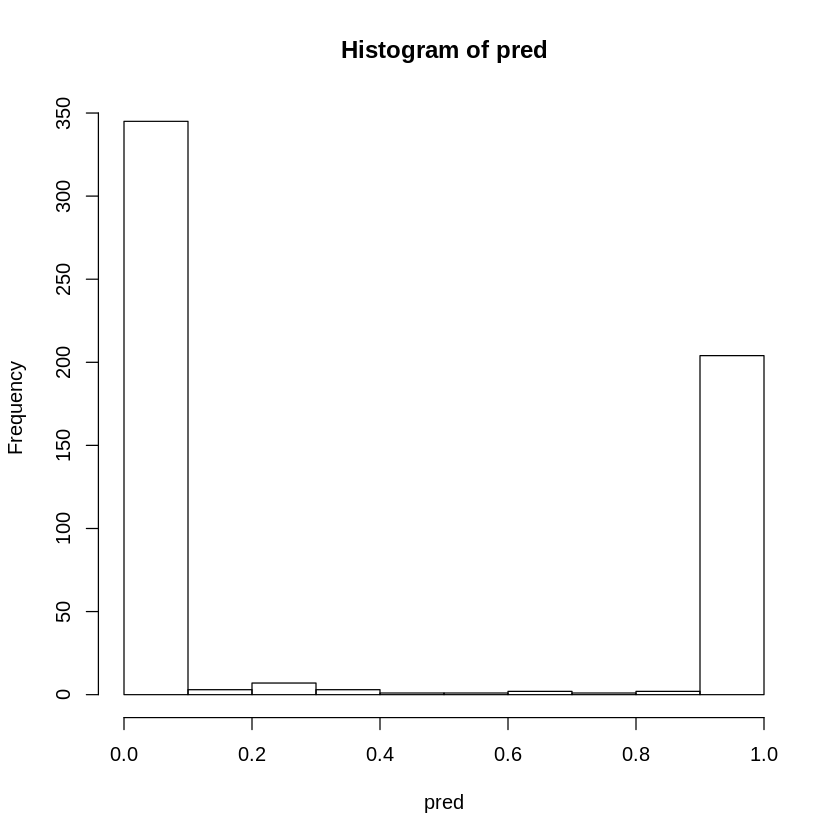

In [39]:
#::GMG::Histograma de predicciones
#::DUDA::¿Interpretación?
hist(x = pred, breaks = 'Sturges')

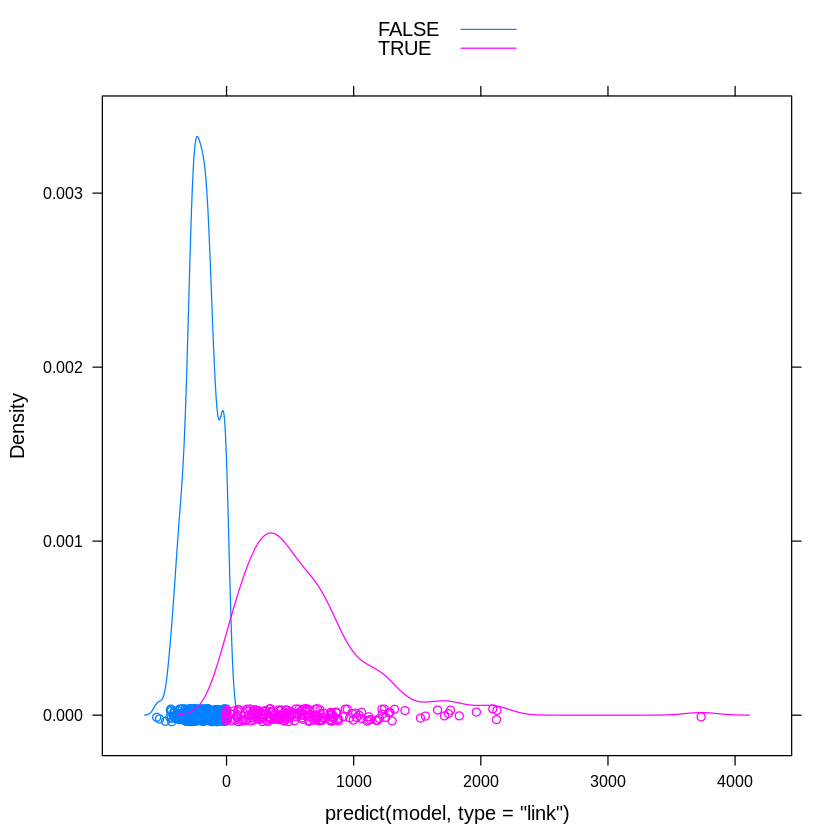

In [32]:
#::GMG::Puesto que tengo lattice puedo ver también el densityplot
#::PTE::Interpretación (?)
#       Cada caso que fue definido como 'B' (0, FALSE) añade un punto azul 
#       y cada caso definido como 'M' (1, True) añade un punto magenta
#       la posición de izda a derecha es el 'link score' asignado ...
densityplot(predict(model,type='link'),
            groups=df$diagnosis != 0, auto.key=T)

Para comprobar la validez de nuestro modelo en la clasificación del cáncer de mama, utilizaremos el índice Área bajo la curva ROC (AUC, por sus siglas en inglés) disponible en la librería `verification` (cargada previamente).

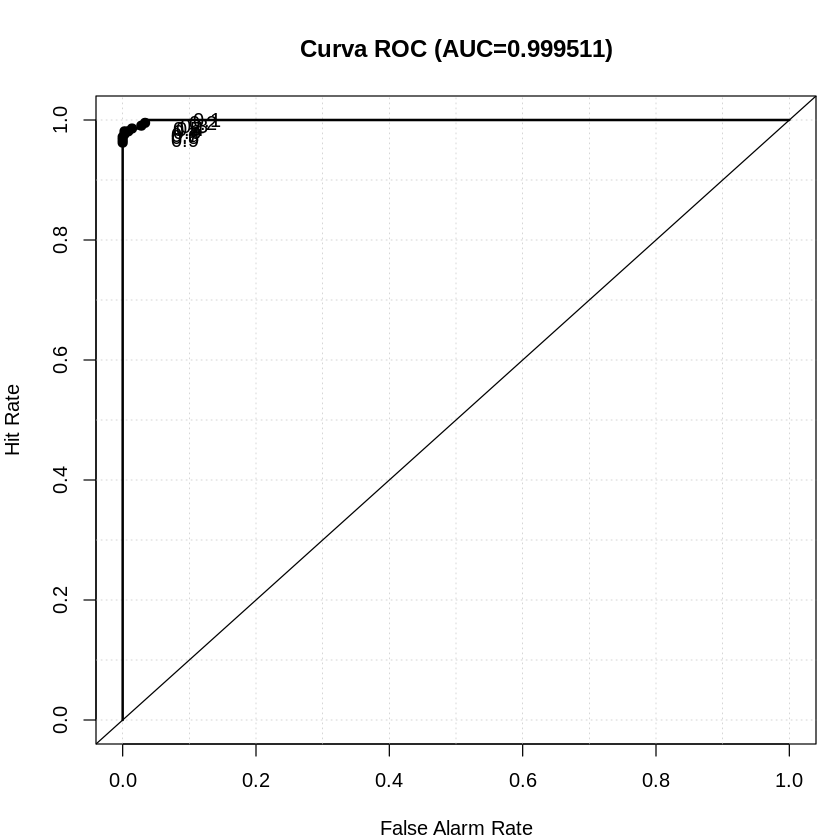

In [35]:
#::GMG:pinto la curca ROC y aparece un clasificador perfecto ...
#      really? :)
#::PTE::Interpretación
roc.plot(df$diagnosis,pred,
  main=sprintf("Curva ROC (AUC=%g)", roc.area(obs = df$diagnosis,pred)$A)
)

### ::GMG:: Generalización

**TAREA 1:** Estudiar la capacidad de generalización del modelo completo mediante una validacion cruzada de tipo _hold out_, es decir, utilizando una parte de los datos para entrenar el modelo y reservando otra para probarlo.

In [22]:
#::GMG::Dividimos los datos en dos mitades de forma aleatoria (hold-out simple)
ind_train <- sample(x = 1:nrow(df), size = round(nrow(df)*0.5), replace = FALSE)
ind_test <- setdiff(1:nrow(df),ind_train)
df_test <- df[ind_test,]
df_train <- df[ind_train,]

In [24]:
#::GMG::Entrenamos con train
model_train <- glm(diagnosis ~ ., df_train, family = "binomial")

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [28]:
summary(model_train)


Call:
glm(formula = diagnosis ~ ., family = "binomial", data = df_train)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-6.143e-05  -2.100e-08  -2.100e-08   2.100e-08   4.988e-05  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)            -3.094e+01  5.138e+04  -0.001    1.000
radius_mean            -1.902e+02  1.235e+06   0.000    1.000
texture_mean           -2.279e+01  4.538e+04  -0.001    1.000
perimeter_mean         -1.187e+02  1.497e+06   0.000    1.000
area_mean               1.601e+02  7.724e+05   0.000    1.000
smoothness_mean         5.084e+01  8.252e+04   0.001    1.000
compactness_mean       -4.051e+01  1.604e+05   0.000    1.000
concavity_mean          8.314e+01  1.684e+05   0.000    1.000
concave.points_mean    -4.476e+01  1.925e+05   0.000    1.000
symmetry_mean           1.249e+01  6.698e+04   0.000    1.000
fractal_dimension_mean -2.274e+01  9.078e+04   0.000    1.000
radius_se              

In [25]:
pred_train <- predict(model_train, df_train[-1], type = 'response')

In [46]:
roc.plot(df_test$diagnosis,pred_train,main=sprintf("Curva ROC (AUC=%g)", 
         roc.area(obs = df_train$diagnosis,pred_train)$A))

Warning message in is.finite(x) & apply(pred, 1, f):
“longer object length is not a multiple of shorter object length”

ERROR: Error in pred[id, ]: (subscript) logical subscript too long


In [29]:
pred_test <- predict(model_train, df_test[-1], type = 'response')

## Selección de variables



### Selección del mejor subconjunto

La función `regsubsets` (`?regsubsets`) de la librería `leaps` nos permite realizar la selección del mejor subconjunto con un número dado de predictores. La sintaxis es similar a la usada para el modelo lineal (`lm`) y, del mismo modo, el comando `summary` nos permite explorar los resultados. Utilizamos el argumento `nvmax` para forzar la utilización de todas las variables (30), ya que por defecto la función regsubsets solo utiliza las 8 primeras.

In [32]:
#install.packages('leaps')
library(leaps)
regfit.full <- regsubsets(diagnosis ~., df, nvmax = 30)
full.summary <- summary(regfit.full)
names(full.summary)

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

La función summary devuelve medidas del ajuste que se pueden usar para seleccionar el mejor modelo. En particular, si revisamos los valores del ajuste, en este caso rsq, se observa que el estadístico va mejorando a medida que aumentamos el número de variables en el modelo. Sin embargo, si nos fijamos en el estadístico BIC (_Bayesian information criterion_), que penaliza la complejidad del modelo, se observa que los valores óptimos se encuentran considerando 11 variables.

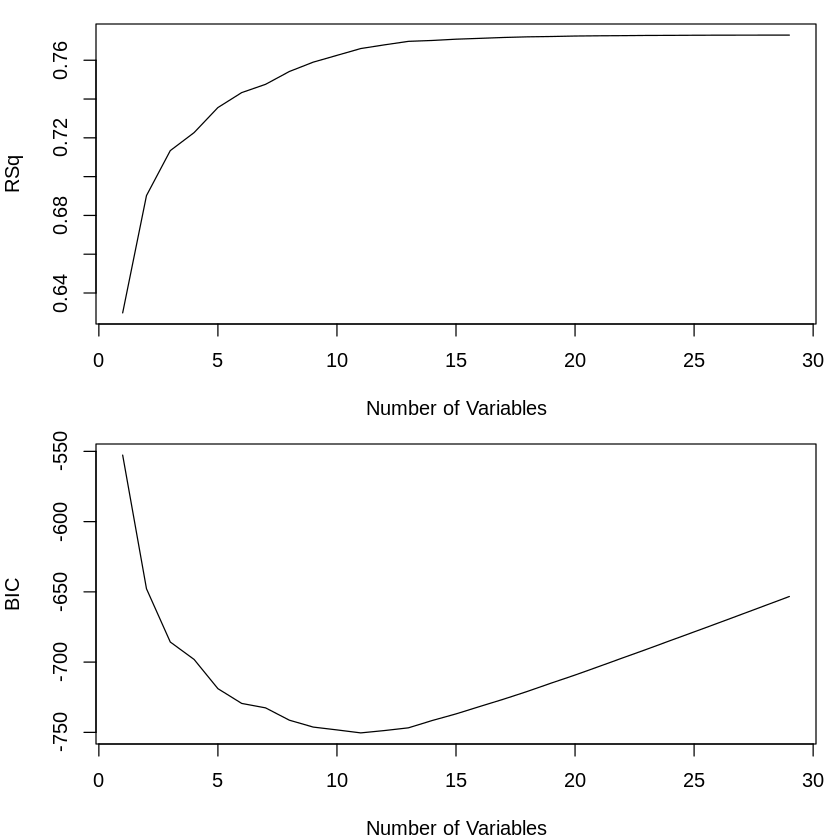

In [33]:
par(mfrow=c(2,1), mar=c(4,4,1,1))
plot(full.summary$rsq,xlab="Number of Variables",ylab="RSq", type="l")
plot(full.summary$bic,xlab="Number of Variables",ylab="BIC", type="l")

In [44]:
max(which(full.summary$rsq <0.77))

[1] 13

In [8]:
which.min(full.summary$bic)

[1] 11

La propia función `regsubsets` incorpora un método para dibujar los resultados clasificados según los diferentes estadísticos (`? plot.regsubsets`)

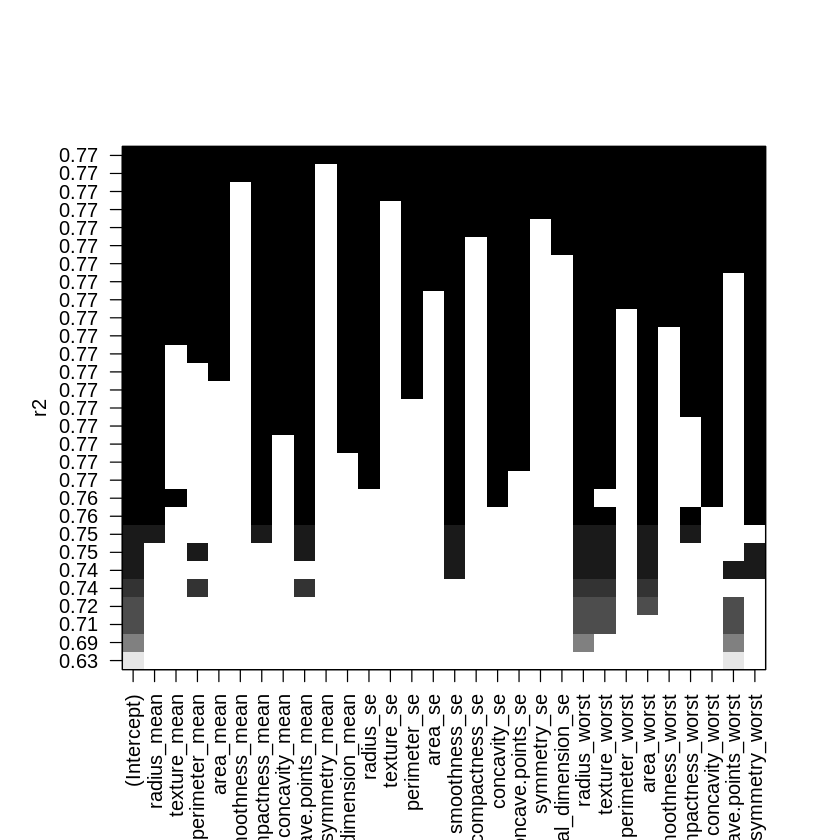

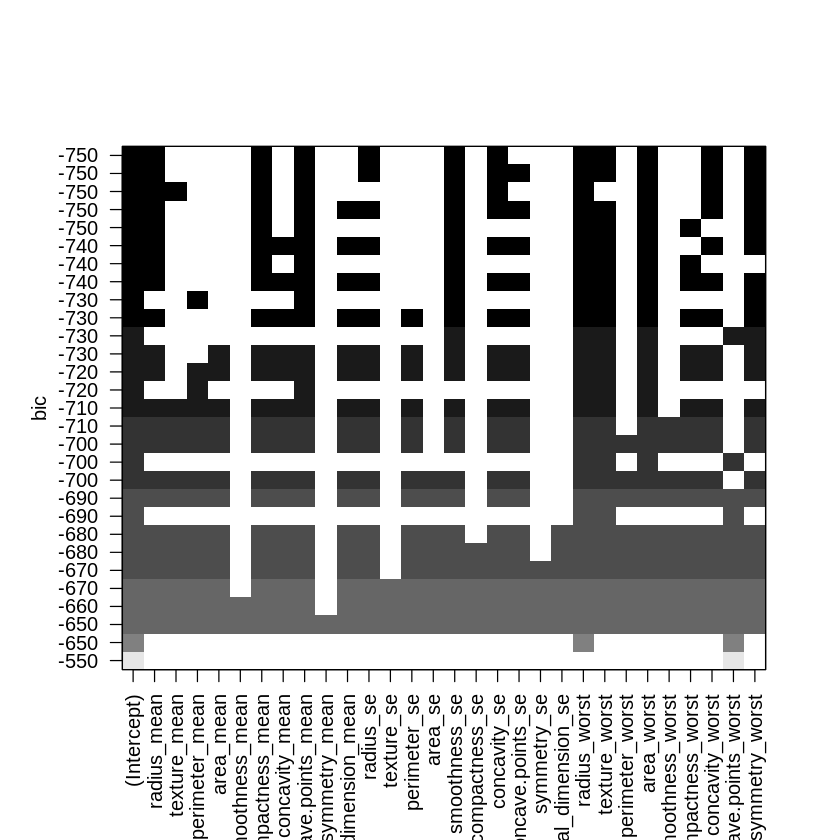

In [9]:
plot(regfit.full, scale ="r2")
plot(regfit.full, scale ="bic")

Cada fila de este gráfico representa el mejor modelo ajustado para un número dado de variables. Cada cuadrado de color representa que la variable entra en ese modelo, mientras que la intensidad del color se asocia con la escala del eje Y. Si, una vez localizado el modelo óptimo (en nuestro caso, el de 11 variables), queremos conocer los coeficientes del modelo, podemos usar la función `coef` con un segundo argumento:

In [10]:
coef(regfit.full, 11)

(Intercept)         radius_mean    compactness_mean concave.points_mean 
         0.37258348         -0.17840169         -0.12933228          0.19664469 
          radius_se       smoothness_se        concavity_se        radius_worst 
         0.05803878          0.06566972         -0.06679611          0.87351926 
      texture_worst          area_worst     concavity_worst      symmetry_worst 
         0.06189087         -0.56390219          0.15446712          0.04610665

### Selección stepwise
Con un leve cambio en los argumentos de la función podemos realizar la selección stepwise, ya sea “forward” o “backward”:

In [11]:
regfit.fwd <- regsubsets(diagnosis~., data = df, nvmax = 30 , method ="forward")
fwd.summary <- summary(regfit.fwd)

**TAREA 2:** Estudiar los predictores seleccionados en este caso. ¿cuál es su múmero óptimo? ¿coinciden con los anteriores?

**TAREA 3:** Comparar la selección realizada por el método backward con los métodos exhaustivo y _forward stepwise_.

Otra opción para realizar la selección _stepwise_ es usar la función `step`, que forma parte del paquete básico `stats` de R:

In [12]:
initialModel_0 <- glm(diagnosis ~ 1, data = df, family=binomial(link="logit"))
initialModel_p <- glm(diagnosis ~ ., data = df, family=binomial(link="logit"))

fw <- step(initialModel_0,
  scope = list(lower = formula(initialModel_0), upper = formula(initialModel_p)),
  direction = "forward"
)
summary(fw)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Start:  AIC=753.44
diagnosis ~ 1



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ perimeter_worst         1   209.48 213.48
+ radius_worst            1   229.11 233.11
+ area_worst              1   230.64 234.64
+ concave.points_worst    1   250.45 254.45
+ concave.points_mean     1   258.92 262.92
+ perimeter_mean          1   304.48 308.48
+ area_mean               1   325.66 329.66
+ radius_mean             1   330.01 334.01
+ area_se                 1   359.50 363.50
+ concavity_mean          1   383.23 387.23
+ concavity_worst         1   437.70 441.70
+ perimeter_se            1   472.83 476.83
+ radius_se               1   480.65 484.65
+ compactness_worst       1   505.55 509.55
+ compactness_mean        1   508.79 512.79
+ texture_worst           1   622.07 626.07
+ symmetry_worst          1   641.42 645.42
+ smoothness_worst        1   641.42 645.42
+ concave.points_se       1   646.01 650.01
+ texture_mean            1   646.52 650.52
+ smoothness_mean         1   673.95 677.95
+ symmetry_mean           1   68

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ smoothness_worst        1   139.18 145.18
+ concave.points_worst    1   149.59 155.59
+ texture_worst           1   159.68 165.68
+ concave.points_mean     1   162.47 168.47
+ smoothness_mean         1   165.18 171.18
+ symmetry_worst          1   167.85 173.85
+ concavity_worst         1   168.55 174.55
+ concavity_mean          1   169.78 175.78
+ radius_mean             1   173.15 179.15
+ compactness_worst       1   175.42 181.42
+ symmetry_mean           1   177.18 183.18
+ fractal_dimension_mean  1   177.62 183.62
+ texture_mean            1   178.63 184.63
+ area_mean               1   180.70 186.70
+ compactness_mean        1   181.84 187.84
+ perimeter_mean          1   183.59 189.59
+ smoothness_se           1   191.06 197.06
+ texture_se              1   195.30 201.30
+ concave.points_se       1   198.67 204.67
+ radius_se               1   199.25 205.25
+ area_se                 1   201.45 207.45
+ symmetry_se             1   20

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ texture_worst           1   103.61 111.61
+ texture_mean            1   106.84 114.84
+ texture_se              1   122.51 130.51
+ area_se                 1   123.42 131.42
+ radius_se               1   124.89 132.90
+ perimeter_se            1   130.42 138.42
+ concavity_mean          1   133.31 141.31
+ symmetry_worst          1   134.45 142.45
+ area_worst              1   134.65 142.65
+ symmetry_se             1   135.31 143.31
+ concave.points_mean     1   135.35 143.35
+ concave.points_worst    1   135.57 143.57
+ concavity_worst         1   135.97 143.97
+ symmetry_mean           1   136.21 144.21
+ concave.points_se       1   136.32 144.32
<none>                        139.18 145.18
+ concavity_se            1   137.42 145.42
+ radius_worst            1   137.53 145.53
+ radius_mean             1   137.66 145.66
+ perimeter_mean          1   137.81 145.81
+ smoothness_se           1   138.54 146.54
+ area_mean               1   13

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=111.61
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance     AIC
+ radius_se               1   87.205  97.205
+ area_se                 1   87.437  97.437
+ perimeter_se            1   94.237 104.237
+ concave.points_mean     1   94.884 104.884
+ concave.points_se       1   98.633 108.633
+ symmetry_mean           1   98.669 108.669
+ concavity_mean          1   98.727 108.727
+ symmetry_se             1   98.826 108.826
+ concave.points_worst    1   99.349 109.349
+ symmetry_worst          1  100.170 110.170
+ area_worst              1  100.526 110.526
+ radius_worst            1  101.505 111.505
<none>                       103.612 111.612
+ smoothness_mean         1  101.830 111.830
+ concavity_worst         1  102.514 112.514
+ concavity_se            1  102.560 112.560
+ texture_mean            1  103.218 113.218
+ fractal_dimension_se    1  103.224 113.224
+ texture_se              1  103.237 113.237
+ smoothness_se           1  103.285 113.285
+ compactness_worst       1  103.360 113.360
+ compactn

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=97.2
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
+ symmetry_worst          1   79.073 91.073
+ concave.points_worst    1   79.196 91.196
+ texture_se              1   82.558 94.558
+ concave.points_mean     1   84.004 96.004
+ concavity_worst         1   84.146 96.146
+ fractal_dimension_se    1   84.287 96.287
+ symmetry_mean           1   84.542 96.542
+ compactness_se          1   84.888 96.888
+ perimeter_se            1   85.151 97.151
+ concavity_mean          1   85.159 97.159
<none>                        87.205 97.205
+ area_worst              1   85.805 97.805
+ smoothness_se           1   85.810 97.810
+ symmetry_se             1   86.025 98.025
+ radius_worst            1   86.030 98.030
+ compactness_mean        1   86.597 98.597
+ fractal_dimension_mean  1   86.729 98.729
+ perimeter_mean          1   86.780 98.780
+ radius_mean             1   86.873 98.873
+ area_mean               1   87.043 99.043
+ texture_mean            1   87.050 99.050
+ smoothness_mean         1   87

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=91.07
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
+ compactness_se          1   74.511 88.511
+ concave.points_worst    1   74.850 88.850
+ fractal_dimension_se    1   75.551 89.551
+ texture_se              1   75.869 89.869
+ area_worst              1   76.196 90.196
+ compactness_mean        1   76.436 90.436
+ perimeter_se            1   76.737 90.737
+ radius_worst            1   76.821 90.821
+ fractal_dimension_mean  1   76.900 90.900
+ concave.points_mean     1   76.974 90.974
<none>                        79.073 91.073
+ compactness_worst       1   77.638 91.638
+ concavity_worst         1   78.142 92.142
+ symmetry_se             1   78.211 92.211
+ concavity_mean          1   78.438 92.438
+ area_se                 1   78.494 92.494
+ smoothness_mean         1   78.730 92.730
+ smoothness_se           1   78.772 92.772
+ symmetry_mean           1   78.803 92.803
+ area_mean               1   78.899 92.899
+ concavity_se            1   78.973 92.973
+ radius_mean             1   78

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=88.51
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
+ concavity_mean          1   65.529 81.529
+ concave.points_worst    1   65.593 81.593
+ concave.points_mean     1   67.066 83.066
+ concavity_worst         1   67.234 83.234
+ concave.points_se       1   68.551 84.551
+ concavity_se            1   69.777 85.777
<none>                        74.511 88.511
+ texture_se              1   72.725 88.725
+ perimeter_se            1   73.232 89.232
+ smoothness_se           1   73.614 89.614
+ area_se                 1   73.733 89.733
+ area_worst              1   74.085 90.085
+ radius_worst            1   74.330 90.330
+ symmetry_se             1   74.406 90.406
+ fractal_dimension_mean  1   74.408 90.408
+ texture_mean            1   74.443 90.443
+ compactness_mean        1   74.471 90.471
+ smoothness_mean         1   74.491 90.491
+ perimeter_mean          1   74.498 90.498
+ compactness_worst       1   74.501 90.501
+ fractal_dimension_se    1   74.502 90.502
+ radius_mean             1   74

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=81.53
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
+ texture_se              1   61.258 79.258
+ concave.points_worst    1   61.850 79.850
+ area_se                 1   63.217 81.217
<none>                        65.529 81.529
+ perimeter_se            1   63.661 81.661
+ area_worst              1   63.951 81.951
+ concave.points_se       1   63.965 81.965
+ radius_worst            1   64.003 82.003
+ compactness_mean        1   64.078 82.078
+ concavity_worst         1   64.328 82.328
+ concave.points_mean     1   64.438 82.438
+ fractal_dimension_mean  1   64.621 82.621
+ smoothness_se           1   64.905 82.905
+ symmetry_mean           1   64.943 82.943
+ fractal_dimension_se    1   65.196 83.196
+ texture_mean            1   65.351 83.351
+ smoothness_mean         1   65.353 83.353
+ symmetry_se             1   65.399 83.399
+ area_mean               1   65.487 83.487
+ concavity_se            1   65.506 83.506
+ radius_mean             1   65.513 83.513
+ perimeter_mean          1   65

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=79.26
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
+ area_se                 1   58.643 78.643
+ concave.points_worst    1   58.739 78.739
+ area_worst              1   59.167 79.167
<none>                        61.258 79.258
+ radius_worst            1   59.387 79.387
+ perimeter_se            1   59.954 79.954
+ compactness_mean        1   60.049 80.049
+ concave.points_se       1   60.277 80.277
+ concave.points_mean     1   60.323 80.323
+ texture_mean            1   60.489 80.489
+ fractal_dimension_mean  1   60.498 80.498
+ fractal_dimension_se    1   60.500 80.500
+ concavity_worst         1   60.579 80.579
+ smoothness_se           1   60.674 80.674
+ area_mean               1   61.103 81.103
+ radius_mean             1   61.162 81.162
+ compactness_worst       1   61.166 81.166
+ smoothness_mean         1   61.214 81.214
+ symmetry_mean           1   61.254 81.254
+ perimeter_mean          1   61.254 81.254
+ concavity_se            1   61.255 81.255
+ symmetry_se             1   61

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=78.64
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se + area_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
+ concave.points_worst    1   54.713 76.713
<none>                        58.643 78.643
+ radius_worst            1   57.113 79.113
+ concave.points_se       1   57.485 79.485
+ concavity_worst         1   57.520 79.520
+ perimeter_se            1   57.525 79.525
+ texture_mean            1   57.593 79.593
+ concave.points_mean     1   57.669 79.669
+ area_worst              1   57.684 79.684
+ compactness_mean        1   58.146 80.146
+ symmetry_se             1   58.236 80.236
+ perimeter_mean          1   58.374 80.374
+ fractal_dimension_se    1   58.503 80.503
+ compactness_worst       1   58.538 80.538
+ fractal_dimension_mean  1   58.549 80.549
+ radius_mean             1   58.590 80.590
+ area_mean               1   58.590 80.590
+ smoothness_se           1   58.599 80.599
+ symmetry_mean           1   58.609 80.609
+ concavity_se            1   58.616 80.616
+ smoothness_mean         1   58.640 80.640


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=76.71
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se + area_se + concave.points_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

                         Df Deviance    AIC
<none>                        54.713 76.713
+ radius_worst            1   52.749 76.749
+ area_worst              1   52.828 76.828
+ compactness_mean        1   52.833 76.833
+ perimeter_se            1   53.106 77.106
+ symmetry_mean           1   53.896 77.896
+ texture_mean            1   53.934 77.934
+ symmetry_se             1   54.209 78.209
+ concavity_worst         1   54.216 78.216
+ smoothness_se           1   54.233 78.233
+ perimeter_mean          1   54.240 78.240
+ smoothness_mean         1   54.399 78.399
+ concavity_se            1   54.555 78.555
+ concave.points_se       1   54.569 78.569
+ radius_mean             1   54.594 78.594
+ compactness_worst       1   54.605 78.605
+ fractal_dimension_mean  1   54.611 78.611
+ fractal_dimension_se    1   54.705 78.705
+ concave.points_mean     1   54.709 78.709
+ area_mean               1   54.710 78.710



Call:
glm(formula = diagnosis ~ perimeter_worst + smoothness_worst + 
    texture_worst + radius_se + symmetry_worst + compactness_se + 
    concavity_mean + texture_se + area_se + concave.points_worst, 
    family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3573  -0.0201  -0.0013   0.0000   3.8553  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.9809     1.1241   1.762 0.078040 .  
perimeter_worst        2.8181     2.4980   1.128 0.259268    
smoothness_worst       1.2907     0.6868   1.879 0.060215 .  
texture_worst          3.2584     0.8392   3.883 0.000103 ***
radius_se             -2.7572     4.6621  -0.591 0.554248    
symmetry_worst         1.0500     0.4957   2.118 0.034164 *  
compactness_se        -2.3356     0.7304  -3.198 0.001384 ** 
concavity_mean         3.1787     1.2999   2.445 0.014472 *  
texture_se            -1.4802     0.8361  -1.770 0.076657 

El objeto de salida es una lista que contiene múltiples elementos. Entre ellos ilustramos el resutado anova que mustra las variables seleccionadas (11 en este caso) en orden adición y el AIC correspondiente (similar al estadístico BIC) .

In [13]:
fw$anova
?step

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
,NA,NA,568,751.44001,753.44001
+ perimeter_worst,-1,541.960065,567,209.47994,213.47994
+ smoothness_worst,-1,70.299730,566,139.18021,145.18021
+ texture_worst,-1,35.568566,565,103.61164,111.61164
+ radius_se,-1,16.406692,564,87.20495,97.20495
+ symmetry_worst,-1,8.132333,563,79.07262,91.07262
+ compactness_se,-1,4.561664,562,74.51095,88.51095
+ concavity_mean,-1,8.982248,561,65.52871,81.52871
+ texture_se,-1,4.270508,560,61.25820,79.25820
+ area_se,-1,2.614785,559,58.64341,78.64341


## Regularización
La regularización consiste en añadir un término a la función objetivo que elimine predictores (regularización L1) o disminuya notablemente su influencia (regularización L2) de tal manera que su capacidad de generalización mejore. El coeficiente estimado estará sesgado, ya que se ha añadido un término a la función objetivo, sin embargo su varianza puede disminuir. Este equilibrio entre el sesgo y la varianza es lo que se conoce como _bias-variance tradeoff_. Si el modelo está demasiado sesgado entonces no se capturarán correctamente las relaciones entre predictando y predictor, sin embargo si está muy poco sesgado, la varianza del coeficiente estimado puede ser alta y no generalizar bien.

En R, para regularizar modelos lineales generalizados se utiliza el paquete `glmnet`. El tipo de regularización viene dado por el valor del parámetro `alpha`: para una regularización L1, `alpha = 1`, para una regularización L2, `alpha = 0`. Ambos tipos de regularización penalizan la norma (1 ó 2, en función de si la regularización es L1 o L2) de los coeficientes estimados. Una consecuencia de la regularización L1 es que indirectamente selecciona variables al hacer estrictamente 0 algunos coeficientes. El número de coeficientes que se hacen 0 viene determinado por el valor de `lambda`. El valor de lambda óptimo se obtiene mediante validación cruzada a través de la función `cv.glmnet`.

En primer lugar, debemos instalar y cargar las librerías que utilizaremos en los ejemplos:

In [14]:
#install.packages("glmnet")
library(glmnet, verbose = FALSE)

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:spam’:

    det

Loading required package: foreach
Loaded glmnet 2.0-16



Ahora veamos qué nos puede aportar una regularización L1 en este caso. Para ello, primero estimamos el valor óptimo de `lambda` mediante la función `cv.glmnet`:

In [15]:
cv <- cv.glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 1)
cv$lambda.1se

[1] 0.006400222

Una vez estimado el valor de lambda, se entrena el modelo regularizado mediante la función `glmnet`.

In [16]:
model.l1 <- glmnet(as.matrix(df[-1]), df$diagnosis, family = "binomial", alpha = 1, lambda = cv$lambda.1se)
ind.coef.no.nulos <- which(as.numeric(coef(model.l1)) != 0)
names(df)[ind.coef.no.nulos]
cat(paste("Number of variables selected:", length(ind.coef.no.nulos)))

[1] "diagnosis"            "texture_mean"         "concave.points_mean" 
 [4] "radius_se"            "fractal_dimension_se" "radius_worst"        
 [7] "texture_worst"        "smoothness_worst"     "concavity_worst"     
[10] "concave.points_worst" "symmetry_worst"

Number of variables selected: 11

Vemos que efectivamente la regularización L1 ha hecho 0 muchos coeficientes eliminando grados de libertad del sistema, salvo las características que se observan en la salida anterior. Podemos ver el sobreajuste de forma cualitativa con la curva ROC:

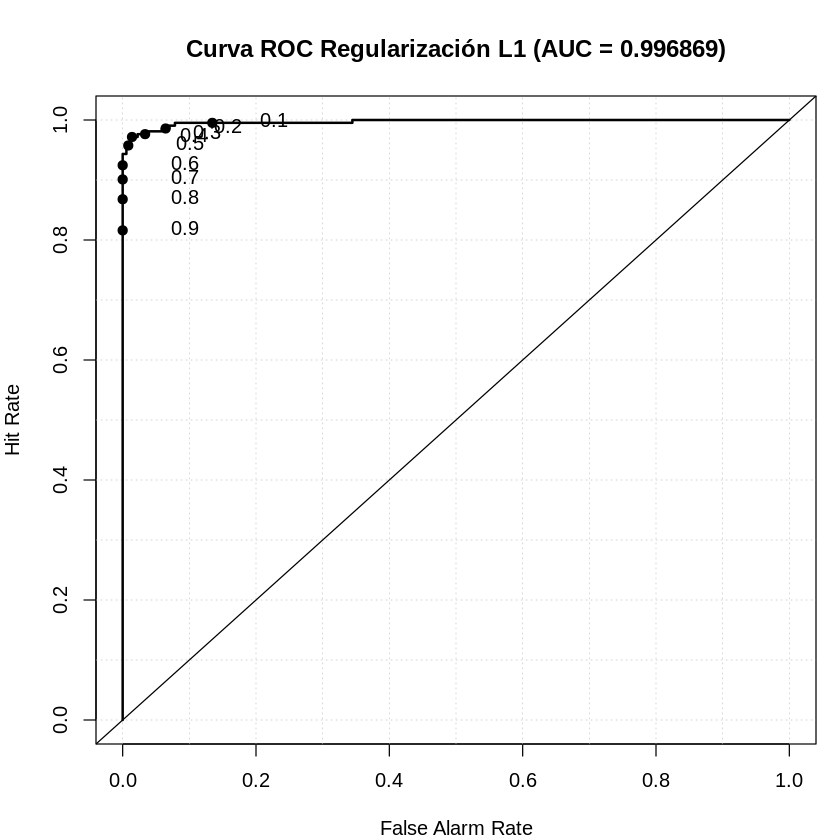

In [17]:
pred.l1 <- predict(model.l1,as.matrix(df[-1]),type = "response")
auc.l1 <- roc.area(df$diagnosis,pred.l1)$A
roc.plot(df$diagnosis,pred.l1, main=sprintf("Curva ROC Regularización L1 (AUC = %g)", auc.l1))

Observamos como, aún con solo 10 variables, el AUC es todavía bastante alto. Por ello se propone la siguiente tarea.

**TAREA 4:** Utilizar una validación cruzada tipo _hold out_ para comprobar si la capacidad de generalización del modelo ha mejorado con la regularización L1.

Si probásemos con la regularización L2 (parámetro alpha = 0), la norma de los módulos se limita pero en este caso ningún coeficiente es 0.

In [18]:
cv2 <- cv.glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 0)
cv2$lambda.1se
model.l2 <- glmnet(as.matrix(df[-1]), df$diagnosis, family = "binomial", alpha = 0, lambda = cv2$lambda.1se)
ind.coef.no.nulos.l2 <- which(as.numeric(coef(model.l2)) != 0)
cat(paste("Number of variables selected:", length(ind.coef.no.nulos.l2)))

[1] 0.05072067

Number of variables selected: 30

Calculamos el AUC para el modelo regularizado con el penalty L2.

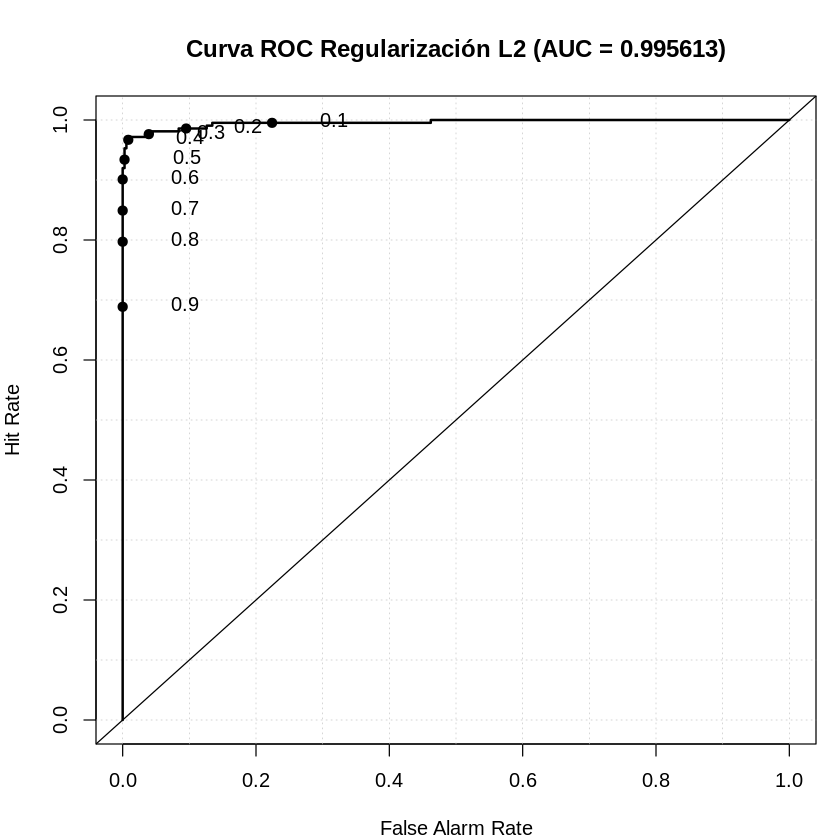

In [19]:
pred.l2 <- predict(model.l2,as.matrix(df[-1]),type = "response")
auc.l2 <- roc.area(df$diagnosis,pred.l2)$A
roc.plot(df$diagnosis,pred.l2, main=sprintf("Curva ROC Regularización L2 (AUC = %g)", auc.l2))

**TAREA 5:** Comprobar la capacidad de generalización del modelo regularizado mediante _ridge regression_ y estudiar la evolución de los valores de los coeficientes en función del valor de `lambda`

**::GMG::** Se puede hacer con S20 pero seguro que hay maneras más eficientes y con un rango de valores espaciado logarítmicamente

**TAREA 6:** Aplicar lo aprendido en esta práctica a otra de las bases de datos de ejemplo.

**::GMG::** Por ejemplo MNIST